<a href="https://colab.research.google.com/github/alvitohawari/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-TensorFlow/blob/main/Chapter_07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

# **Ensemble Learning and Random Forests**

Suppose you pose a complex question to thousands of random people, then aggregate
their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of pre‐
dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an Ensemble method.
As an example of an Ensemble method, you can train a group of Decision Tree classi‐
fiers, each on a different random subset of the training set. To make predictions, you
obtain the predictions of all the individual trees, then predict the class that gets the
most votes (see the last exercise in Chapter 6). Such an ensemble of Decision Trees is
called a Random Forest, and despite its simplicity, this is one of the most powerful
Machine Learning algorithms available today.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers
Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
You may have a Logistic Regression classifier, an SVM classifier, a Random Forest
classifier, a K-Nearest Neighbors classifier, and perhaps a few more (see Figure 7-1).

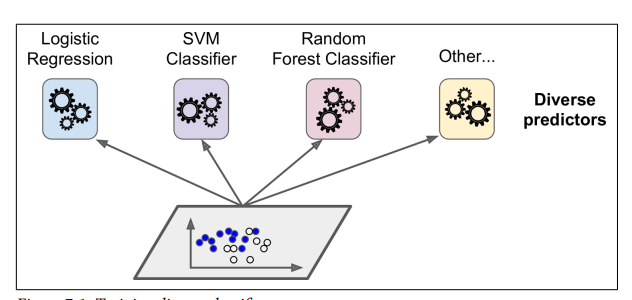
### **Figure 7-1. Training diverse classifiers**
A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classi‐
fier is called a hard voting classifier (see Figure 7-2).

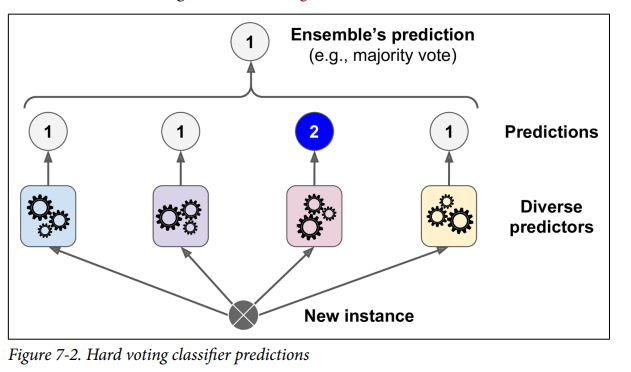

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a weak learner (mean‐
ing it does only slightly better than random guessing), the ensemble can still be a
strong learner (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse.

In [ ]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

**Code to generate Figure 7–3. The law of large numbers:**

Saving figure law_of_large_numbers_plot


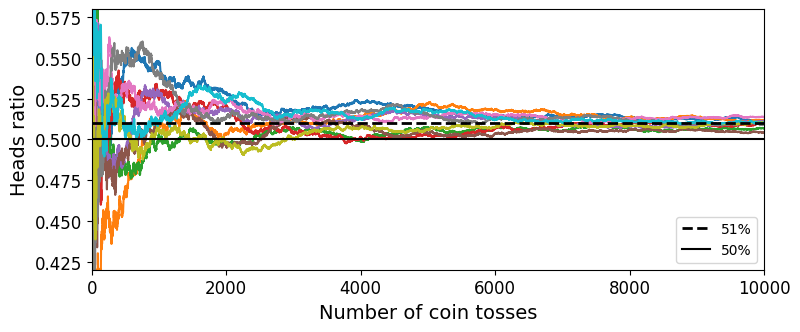

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

### **Figure 7-3. The law of large numbers**

Figure 7-3 shows 10 series of biased coin tosses. You can
see that as the number of tosses increases, the ratio of heads approaches 51%. Eventu‐
ally all 10 series end up so close to 51% that they are consistently above 50%.

Let's use the moons dataset:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

The following code creates and trains a voting classifier in Scikit-Learn, composed of
three diverse classifiers (the training set is the moons dataset, introduced in Chap‐
ter 5)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft voting:

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


There you have it! The voting classifier slightly outperforms all the individual
classifiers

# Bagging and **Pasting**
One way to get a diverse set of classifiers is to use very different training algorithms,
as just discussed. Another approach is to use the same training algorithm for every
predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called bagging
(short for boot‐
strap aggregating
). When sampling is performed without replacement, it is called
pasting.
## Bagging and Pasting in Scikit-Learn
Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClas
sifier class (or BaggingRegressor for regression). The following code trains an
ensemble of 500 Decision Tree classifiers:5
 each is trained on 100 training instances
randomly sampled from the training set with replacement (this is an example of bag‐
ging, but if you want to use pasting instead, just set bootstrap=False). The n_jobs
parameter tells Scikit-Learn the number of CPU cores to use for training and predic‐
tions (–1 tells Scikit-Learn to use all available cores):


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


**Code to generate Figure 7–5. A single Decision Tree (left) versus a bagging ensemble of 500 trees (right):**

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


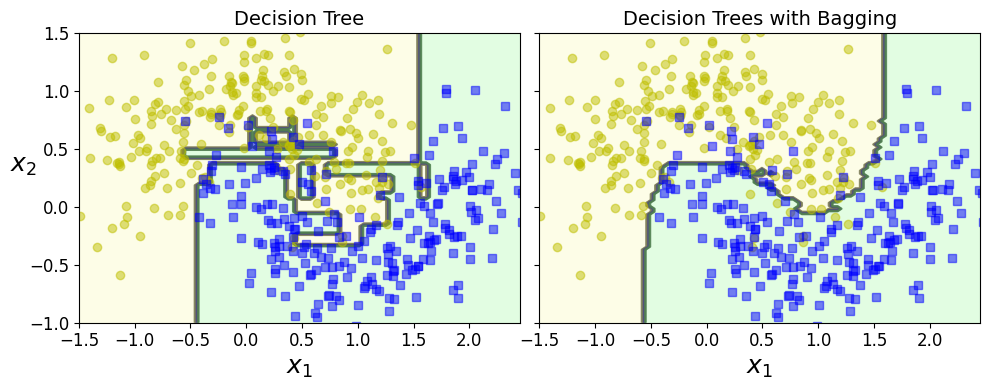

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### **Figure 7-5. A single Decision Tree (left) versus a bagging ensemble of 500 trees (right)**
Figure 7-5 compares the decision boundary of a single Decision Tree with the deci‐
sion boundary of a bagging ensemble of 500 trees (from the preceding code), both
trained on the moons dataset. As you can see, the ensemble’s predictions will likely
generalize much better than the single Decision Tree’s predictions: the ensemble has a
comparable bias but a smaller variance (it makes roughly the same number of errors
on the training set, but the decision boundary is less irregular).

## **Out-of-Bag evaluation**
With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor.6
 The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
for all predictors.

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to
request an automatic oob evaluation after training. The following code demonstrates
this. The resulting evaluation score is available through the oob_score_ variable:


In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [ ]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

We get 91.2% accuracy on the test set—close enough!

## **Random Forests**
As we have discussed, a Random Forest9
 is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set. Instead of building a BaggingClassifier and pass‐
ing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier
class, which is more convenient and optimized for Decision Trees10 (similarly, there is
a RandomForestRegressor class for regression tasks). The following code uses all
available CPU cores to train a Random Forest classifier with 500 trees (each limited
to maximum 16 nodes):


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is equivalent to a bag of decision trees:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

np.float64(1.0)

## **Feature Importance**
Yet another great quality of Random Forests is that they make it easy to measure the
relative importance of each feature. Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest). More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it
(see Chapter 6).

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [ ]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

The following figure overlays the decision boundaries of 15 decision trees. As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary:

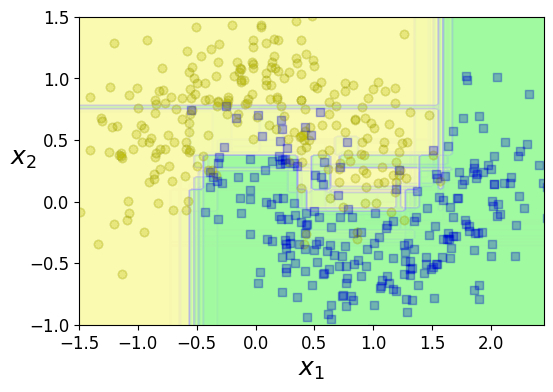

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### Figure 7-8. Decision boundaries of consecutive predictors
Figure 7-8 shows the decision boundaries of five consecutive predictors on the
moons dataset (in this example, each predictor is a highly regularized SVM classifier
with an RBF kernel14). The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and
so on. The plot on the right represents the same sequence of predictors, except that
the learning rate is halved (i.e., the misclassified instance weights are boosted half as
much at every iteration). As you can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

**Code to generate Figure 7–6. MNIST pixel importance (according to a Random Forest classifier):**

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


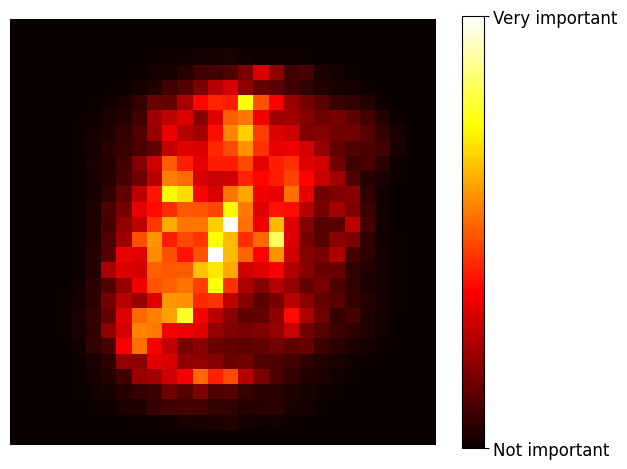

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting
Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its prede‐
cessor. There are many boosting methods available, but by far the most popular areAdaBoost (short for Adaptive Boosting) and Gradient Boosting. Let’s start with Ada‐
Boost.


 (short for Adaptive Boosting) and Gradient Boosting. Let’s start with Ada‐
Boost.

## AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predic‐
tors focusing more and more on the hard cases. This is the technique used by
AdaBoost.
For example, when training an AdaBoost classifier, the algorithm first trains a base
classifier (such as a Decision Tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes predic‐
tions on the training set, updates the instance weights, and so on (see Figure 7-7).

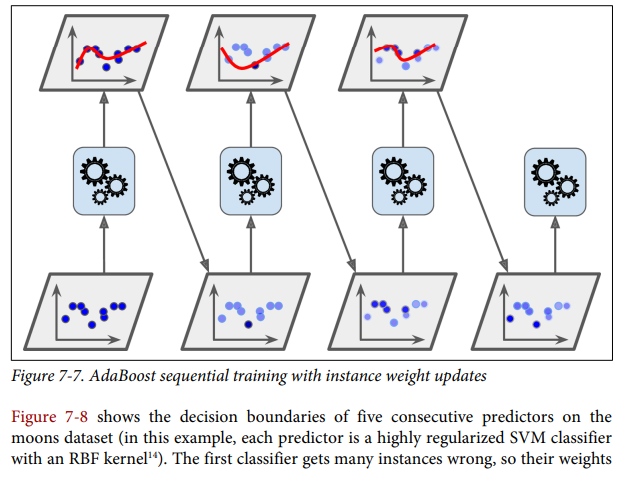

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [ ]:
plot_decision_boundary(ada_clf, X, y)

**Code to generate Figure 7–8. Decision boundaries of consecutive predictors:**

Saving figure boosting_plot


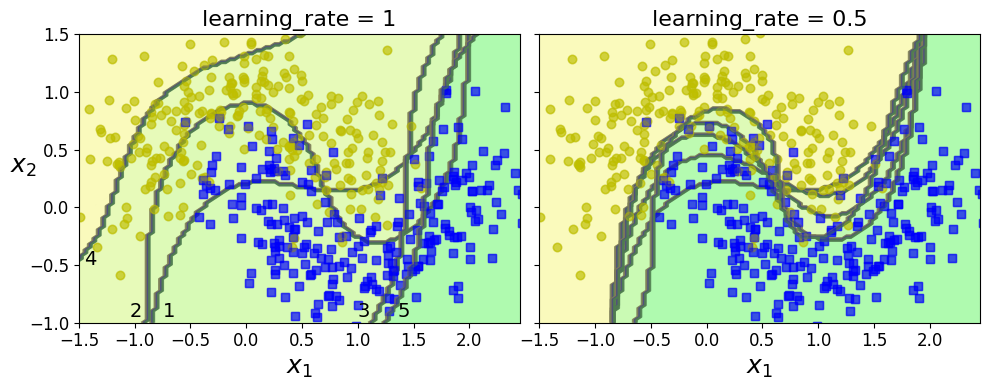

In [ ]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### **Figure 7-8. Decision boundaries of consecutive predictors**
Figure 7-8 shows the decision boundaries of five consecutive predictors on the
moons dataset (in this example, each predictor is a highly regularized SVM classifier
with an RBF kernel14). The first classifier gets many instances wrong, so their weightsget boosted. The second classifier therefore does a better job on these instances, and
so on. The plot on the right represents the same sequence of predictors, except that
the learning rate is halved (i.e., the misclassified instance weights are boosted half as
much at every iteration). As you can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

## **Gradient Boosting**
Another very popular boosting algorithm is Gradient Boosting. Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.
Let’s go through a simple regression example, using Decision Trees as the base predic‐
tors (of course, Gradient Boosting also works great with regression tasks). This is
called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s
fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic train‐
ing set):

Let create a simple quadratic datase


In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Now let's train a decision tree regressor on this dataset:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
X_new = np.array([[0.8]])

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

array([0.75026781])

**Code to generate Figure 7–9. In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions:**

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


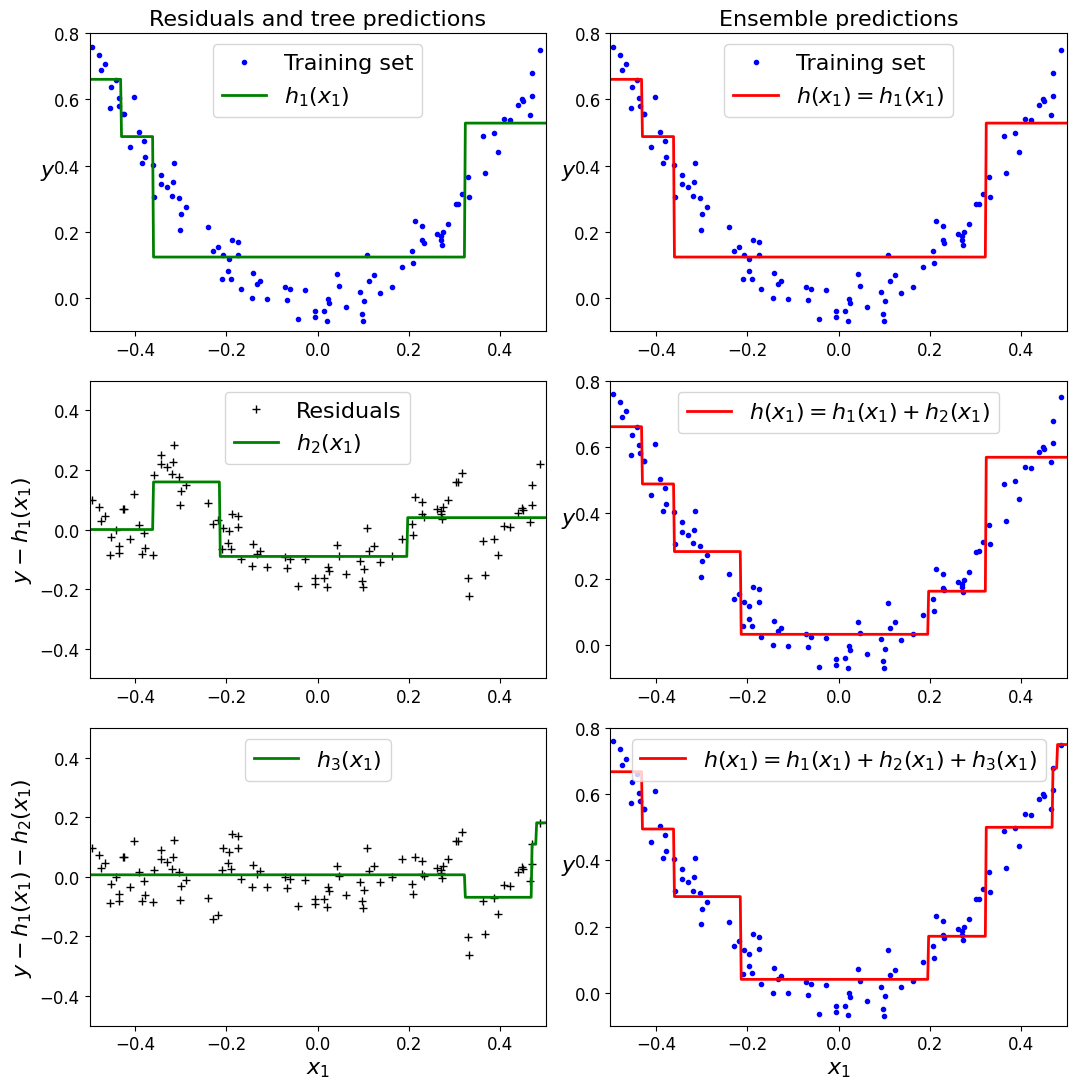

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

### **Figure 7-9. In this depiction of Gradient Boosting, the first predictor (top left) is trained**
### **normally, then each consecutive predictor (middle left and lower left) is trained on the**
### **previous predictor’s residuals; the right column shows the resulting ensemble’s predictions**

Now let's try a gradient boosting regressor:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**Code to generate Figure 7–10. GBRT ensembles with not enough predictors (left) and too many (right):**

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


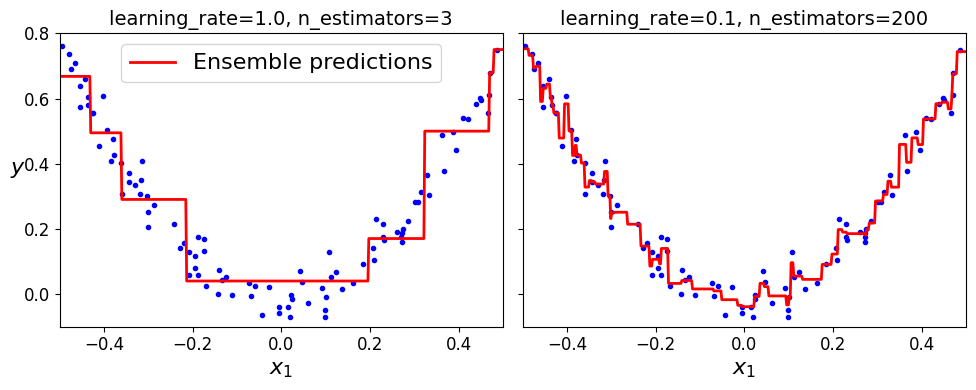

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

### **Figure 7-10. GBRT ensembles with not enough predictors (left) and too many (right)**
The learning_rate hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1, you will need more trees in the ensemble to fit the train‐
ing set, but the predictions will usually generalize better. This is a regularization tech‐
nique called shrinkage. Figure 7-10 shows two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.

In order to find the optimal number of trees, you can use early stopping (see Chap‐
ter 4). A simple way to implement this is to use the staged_predict() method: it
returns an iterator over the predictions made by the ensemble at each stage of train‐
ing (with one tree, two trees, etc.). The following code trains a GBRT ensemble with
120 trees, then measures the validation error at each stage of training to find the opti‐
mal number of trees, and finally trains another GBRT ensemble using the optimal
number of trees:


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(56),
                          random_state=42)

**Code to generate Figure 7–11. Tuning the number of trees using early stopping:**

The validation errors are represented on the left of Figure 7-11, and the best model’s
predictions are represented on the right.

In [ ]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


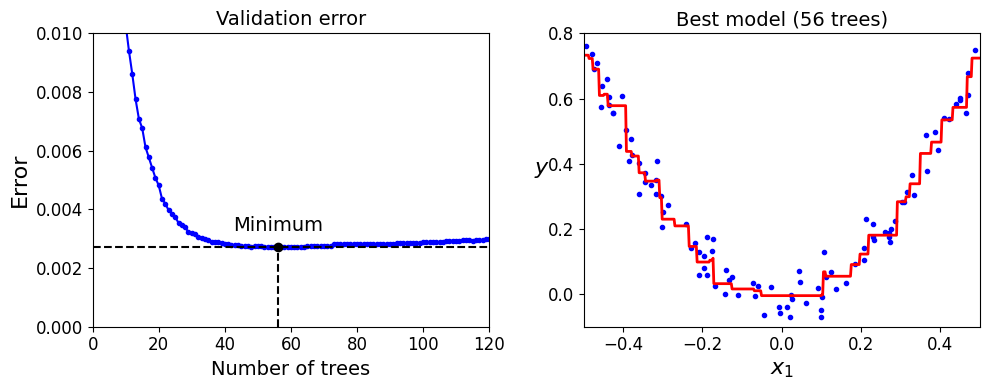

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

### **Figure 7-11. Tuning the number of trees using early stopping**

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting warm_start=True, which makes ScikitLearn keep existing trees when the fit() method is called, allowing incremental
training. The following code stops training when the validation error does not
improve for five iterations in a row:

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

The GradientBoostingRegressor class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instan‐
ces, selected randomly. As you can probably guess by now, this technique trades a
higher bias for a lower variance. It also speeds up training considerably. This is called
Stochastic Gradient Boosting.

In [ ]:
print(gbrt.n_estimators)

61


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**Using XGBoost:**

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.004644479346317078


In [ ]:
if xgboost is not None:
    # Re-initialize xgb_reg to demonstrate early stopping from a fresh start
    xgb_reg = xgboost.XGBRegressor(random_state=42)

    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)])
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
[8]	validation_0-rmse:0.05682
[9]	validation_0-rmse:0.05811
[10]	validation_0-rmse:0.05983
[11]	validation_0-rmse:0.06033
[12]	validation_0-rmse:0.06100
[13]	validation_0-rmse:0.06179
[14]	validation_0-rmse:0.06206
[15]	validation_0-rmse:0.06235
[16]	validation_0-rmse:0.06230
[17]	validation_0-rmse:0.06272
[18]	validation_0-rmse:0.06281
[19]	validation_0-rmse:0.06308
[20]	validation_0-rmse:0.06294
[21]	validation_0-rmse:0.06299
[22]	validation_0-rmse:0.06281
[23]	validation_0-rmse:0.06325
[24]	validation_0-rmse:0.06369
[25]	validation_0-rmse:0.06358
[26]	validation_0-rmse:0.06395
[27]	validation_0-rmse:0.06394
[28]	validation_0-rmse:0.06429
[29]	validation_0-rmse:0.06447
[30]	validation_0-rmse:0.06471
[31]	validation_0-rmse:0.06500
[32]	validation_0-

In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

21.1 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

77.2 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### **Stacking**
The last Ensemble method we will discuss in this chapter is called stacking (short for
stacked generalization).18 It is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble,
why don’t we train a model to perform this aggregation? Figure 7-12 shows such an
ensemble performing a regression task on a new instance. Each of the bottom three
predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor
(called a blender, or a meta learner) takes these predictions as inputs and makes the
final prediction (3.0).

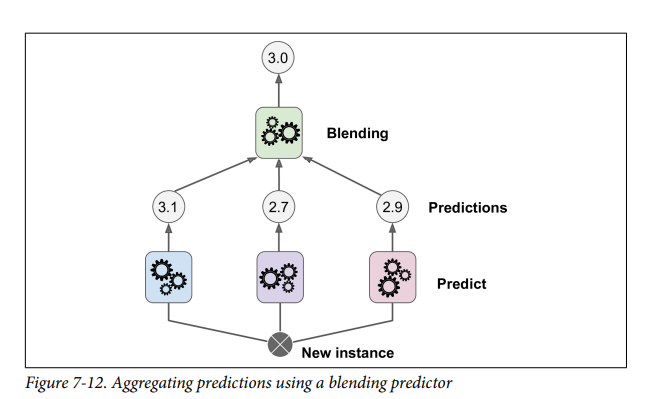
Figure 7-12. Aggregating predictions using a blending predictor

To train the blender, a common approach is to use a hold-out set.19 Let’s see how it
works. First, the training set is split into two subsets. The first subset is used to train
the predictors in the first layer (see Figure 7-13).

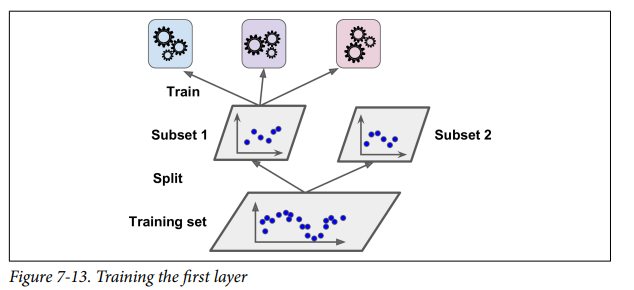

Next, the first layer’s predictors are used to make predictions on the second (heldout) set (see Figure 7-14). This ensures that the predictions are “clean,” since the predictors never saw these instances during training. For each instance in the hold-out set, there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set 3D), and keeping
the target values. The blender is trained on this new training set, so it learns to pre‐
dict the target value, given the first layer’s predictions.



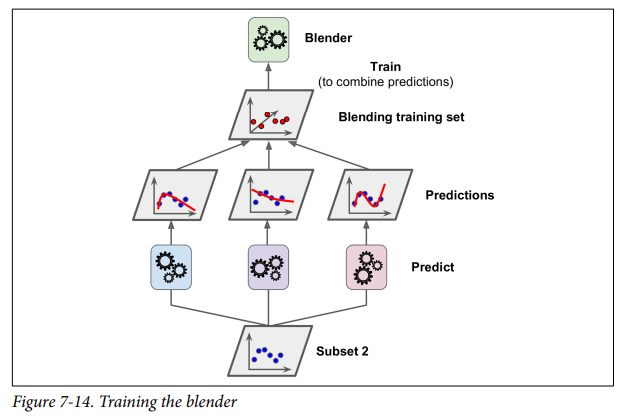

It is actually possible to train several different blenders this way (e.g., one using Lin‐
ear Regression, another using Random Forest Regression), to get a whole layer of
blenders. The trick is to split the training set into three subsets: the first one is used to
train the first layer, the second one is used to create the training set used to train the
second layer (using predictions made by the predictors of the first layer), and the
third one is used to create the training set to train the third layer (using predictions
made by the predictors of the second layer). Once this is done, we can make a predic‐
tion for a new instance by going through each layer sequentially, as shown in
Figure 7-15.
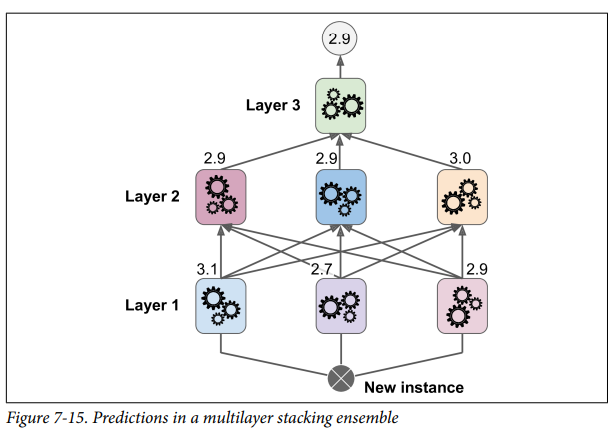
